In [1]:
from IPython import get_ipython



  # Homework 9

  Kalin Gibbons
  2020-04-07

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



In [3]:
# %matplotlib inline
# %matplotlib widget
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
plt.rcParams['figure.figsize'] = (9, 5.5)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'Times New Roman'



It turns out that my version of Jupyter has some issues handling memory, and it likes
to crash with this vectorized code. All of the functions within the notebook 
should be imporoved by allowing for batch processing.



In [4]:
final_run = True  # NOTE: Requires > 16GB of ram in VSCode.
                  #       Jupyter will still crash 90% of the time.



  <br/>
  <br/>

  # Problem 1

  ---

  ## Problem 6.7

  Consider pricing a European call option on an underlying stock with current
  price $S^{(0)} = 50$, strike price $K = 52$, and volatility $\sigma = 0.5$.
  Suppose that there are $N = 30$ days to maturity and that the risk-free rate
  of return is $r = 0.05$.

  * (a) Confirm that the fair price for this option is 2.10 when the payoff is
    based on $S^{(30)}$ (i.e., a standard option with payoff as in (6.74)).

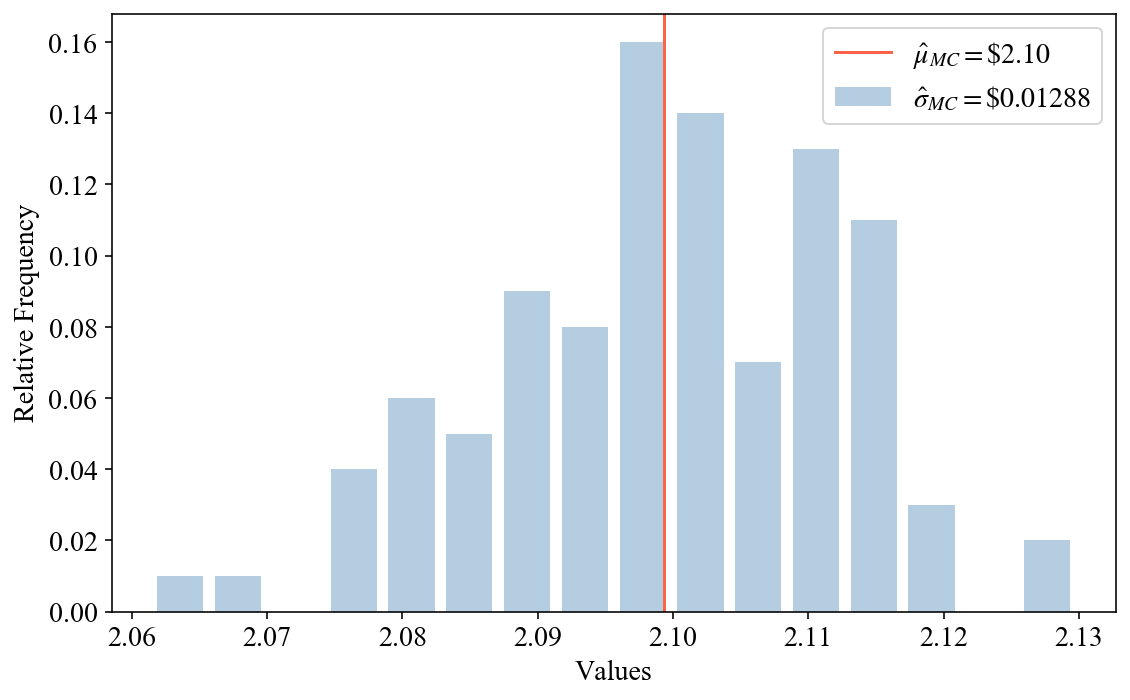

In [5]:
DAYS_PER_YEAR = 365
n_sample = int(1e5) if final_run else int(1e3)
replication = int(1e2)
maturity = 30
init_val = 50
rate = 0.05
volatility = 0.5
strike_price = 52

# maturity = 50
# init_val = 100
# rate = 0.05
# volatility = 0.3
# strike_price = 102


def stock_value(day, z):
    lft_trm = (rate - volatility ** 2 / 2) * day / DAYS_PER_YEAR
    rit_trm = volatility * z * np.sqrt(day / DAYS_PER_YEAR)
    current_val_ary = init_val * np.exp(lft_trm + rit_trm)
    return current_val_ary


def fair_price(day, z):
    lft_fact = np.exp(-rate * day / DAYS_PER_YEAR)
    val = stock_value(day, z)
    delta = val - strike_price
    zeros = np.zeros_like(delta)
    rit_fact = np.dstack((delta, zeros)).max(axis=2)
    fair_ary = (lft_fact * rit_fact).mean(axis=1)
    return fair_ary


def rel_freq_hist(x, *args, **kwargs):
    wts = np.full_like(x, 1 / x.size)
    hist_out = plt.hist(x, weights=wts, *args, **kwargs)
    plt.xlabel('Values')
    plt.ylabel('Relative Frequency')
    return hist_out


def plot_mc(result_ary, bin_color, line_color, labels, *args, **kwargs):
    avg = result_ary.mean()
    std = result_ary.std()
    hst_lbl = f'$\\hat{{\\sigma}}_{{{labels[0]}}} = \${std:.5f}$'
    hist = rel_freq_hist(result_ary, *args, bins=16, rwidth=0.8,
                         color=bin_color, alpha=0.4, label=hst_lbl, **kwargs)

    ln_lbl = f'$\\hat{{\mu}}_{{{labels[1]}}} = \${avg:.2f}$'
    line = plt.axvline(avg, color=line_color, label=ln_lbl)
    return (hist, line)


z = np.random.randn(replication, n_sample)
fair_mc = fair_price(maturity, z)
plt.figure()
plot_mc(fair_mc, bin_color='SteelBlue', line_color='Tomato',
        labels=('MC', 'MC'))
plt.legend()
if final_run:
    plt.show()



  The fair price matches, at $2.10.

  * (b) Consider the analogous Asian option (same $S^{(0)}, K, \sigma, N,$ and
    $r$) with payoff based on the arithmetic mean stock price during the
    holding period, as in (6.77). Using simple Monte Carlo, estimate the fair
    price for this option.

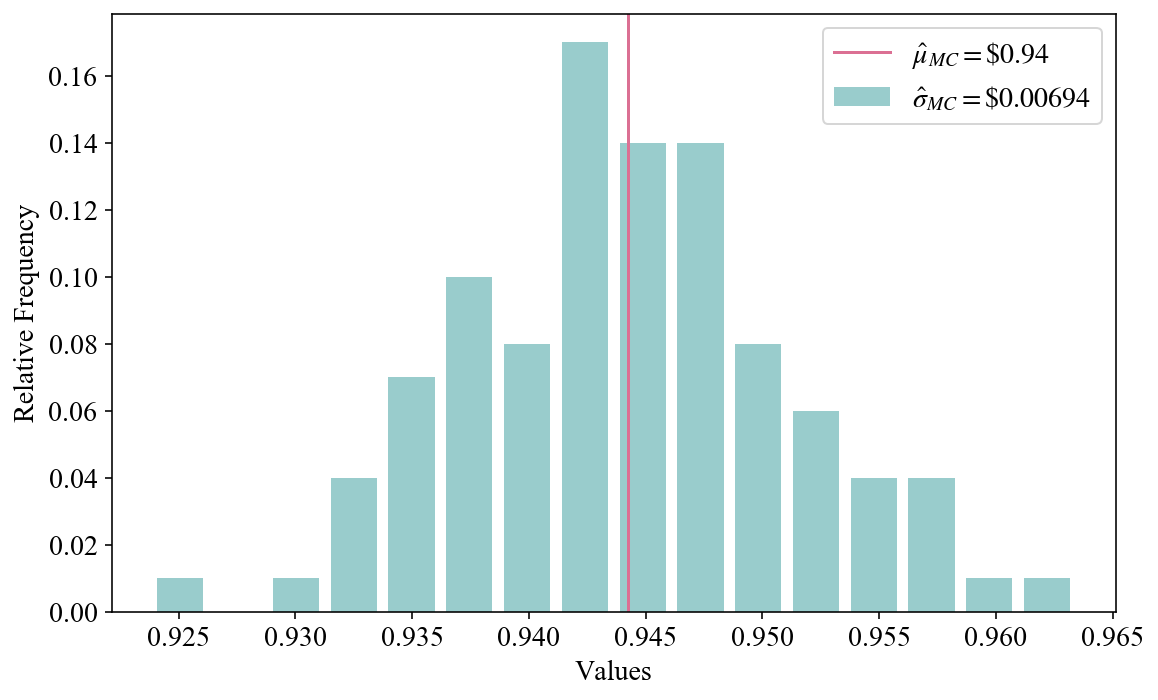

In [6]:
def update_value(prev_val, z):
    lft_trm = (rate - volatility ** 2 / 2) / DAYS_PER_YEAR
    rit_trm = volatility * z / np.sqrt(DAYS_PER_YEAR)
    scaler = np.exp(lft_trm + rit_trm)
    new_val = prev_val * scaler
    return new_val


def average_value(today, z, geometric=False):
    dims = list(z.shape)
    dims[-1] = today + 1
    val_ary = np.full(dims, np.nan)
    val_ary[:, :, 0] = init_val
    for day in range(1, today + 1):
        prev_day = day - 1
        deviates = z[:, :, prev_day]
        prev_vals = val_ary[:, :, prev_day]
        val_ary[:, :, day] = update_value(prev_vals, deviates)
    if geometric:
        avg_values = stats.mstats.gmean(val_ary[:, :, 1:], axis=2)
    else:
        avg_values = val_ary[:, :, 1:].mean(axis=2)
    return avg_values


def asian_price(today, z, geometric=False):
    avg_values = average_value(today, z, geometric)
    lft_fact = np.exp(-rate * today / DAYS_PER_YEAR)
    delta = avg_values - strike_price
    zeros = np.zeros_like(delta)
    rit_fact = np.dstack((delta, zeros)).max(axis=2)
    fair_price = (lft_fact * rit_fact).mean(axis=1)
    return fair_price


z = np.random.randn(replication, n_sample, maturity)
asian_mc = asian_price(maturity, z)
plt.figure()
plot_mc(asian_mc, bin_color='Teal', line_color='PaleVioletRed',
        labels=('MC', 'MC'))
plt.legend()
if final_run:
    plt.show()


  * (c) Improve upon the estimate in (b) using the control variate strategy
    described in Example 6.13.

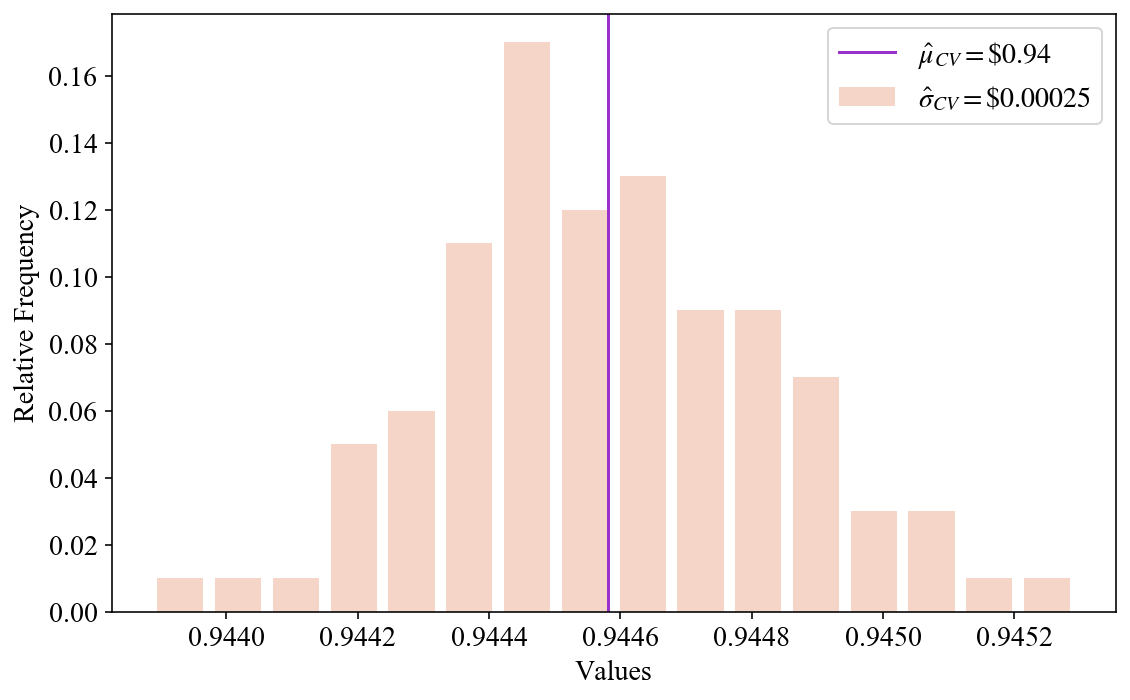

In [7]:
def geo_asian_price(maturity, day, init_val, rate, volatility, strike_price):
    c3 = 1 + 1 / maturity
    c2 = volatility * (c3 * day / 1095 * (1 + 1 / 2 / maturity)) ** 0.5

    # c1
    lft_term = np.log(init_val / strike_price)
    mid_term = c3 * day / 730 * (rate - volatility ** 2 / 2)
    rit_term = c3 * volatility ** 2 * day / 1095 * (1 + 1 / 2 / maturity)
    c1 = 1 / c2 * np.sum((lft_term, mid_term, rit_term))

    F = stats.norm.cdf
    lft_in = (-day * (rate + c3 * volatility ** 2 / 6) * (1 - 1 / maturity)
              / 730)
    lft_term = init_val * F(c1) * np.exp(lft_in)
    rit_term = -strike_price * F(c1 - c2) * np.exp(-rate * day / DAYS_PER_YEAR)
    geometric_price = np.sum((lft_term, rit_term))
    return geometric_price


# Test that nasty equation against the book example
geo_test = geo_asian_price(50, 50, 100, 0.05, 0.3, 102)
assert round(geo_test, 2) == 1.83, 'Eq 6.79 does not match Ex.6.12!!'


def cv_asian_price(today, z, lam):
    mu_mc = asian_price(today, z)
    theta_mc = asian_price(today, z, geometric=True)
    theta = geo_asian_price(maturity, today, init_val, rate, volatility,
                            strike_price)

    mu_cv = mu_mc + lam * (theta_mc - theta)
    return mu_cv


lam = -1
asian_cv = cv_asian_price(maturity, z, lam)
plt.figure()
plot_mc(asian_cv, bin_color='DarkSalmon', line_color='DarkOrchid',
        labels=('CV', 'CV'))
plt.legend()
if final_run:
    plt.show()


  * (d) Try an antithetic approach to estimate the fair price for the option
    described in part (b).

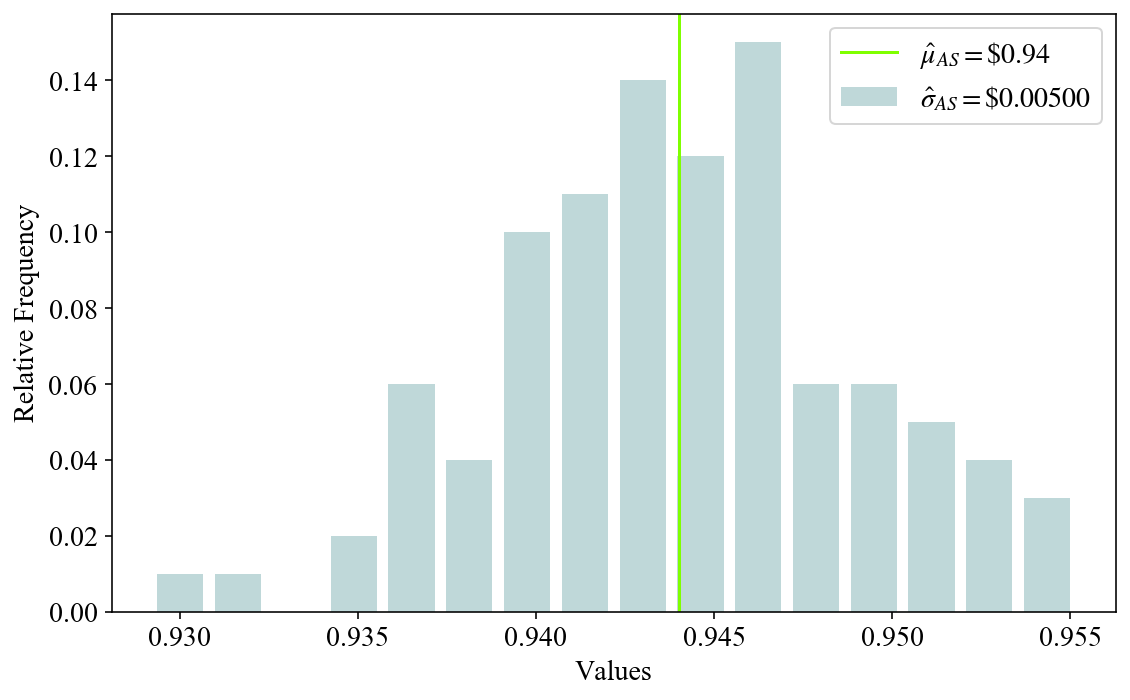

In [8]:
plt.figure()
half_z = z[:, 0:n_sample // 2, :]
mu_1 = asian_price(maturity, half_z)
mu_2 = asian_price(maturity, -half_z)
asian_as = np.vstack((mu_1, mu_2)).mean(axis=0)
plot_mc(asian_as, bin_color='CadetBlue', line_color='Chartreuse',
        labels=('AS', 'AS'))
plt.legend()
if final_run:
    plt.show()


  * (e) Using simulation and/or analysis, compare the sampling distributions of
    the estimators in (b), (c), and (d).

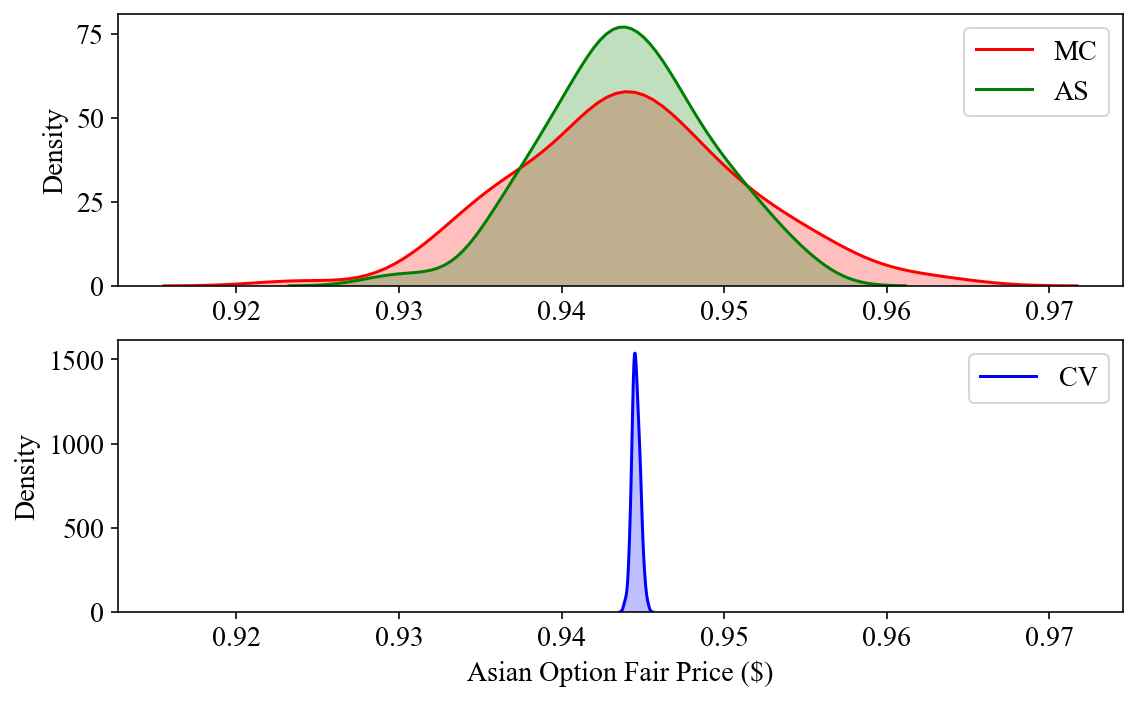

Antithetic sampling variance reduction imporoves as correlation approaches -1.
A correlation near zero will be less pronounced.

Correlation between antithetic samples was -0.3562.
Antithetic sampling reduced variance by 27.92%.

Control variate sampling reduced variance by 96.36%.


In [9]:
fig = plt.figure()
top_ax = fig.add_subplot(211)
sns.kdeplot(asian_mc, shade=True, color='r', label='MC', ax=top_ax)
sns.kdeplot(asian_as, shade=True, color='g', label='AS', ax=top_ax)

bot_ax = fig.add_subplot(212)
sns.kdeplot(asian_cv, shade=True, color='b', label='CV', ax=bot_ax)

xlims = np.vstack((top_ax.get_xlim(), bot_ax.get_xlim()))
xlims = (xlims.min(axis=0)[0], xlims.max(axis=0)[1])
top_ax.set_xlim(xlims)
bot_ax.set_xlim(xlims)
top_ax.set_ylabel('Density')
bot_ax.set_ylabel('Density')
bot_ax.set_xlabel('Asian Option Fair Price ($)')
plt.legend()
if final_run:
    plt.show()


def percent_change(old, new):
    return np.abs((new - old) / old) * 100


mc_std = asian_mc.std()
as_std = asian_as.std()
cv_std = asian_cv.std()
dec_as = percent_change(mc_std, as_std)
dec_cv = percent_change(mc_std, cv_std)
as_corr = np.corrcoef(mu_1, mu_2)[0,1]
msg = ('Antithetic sampling variance reduction imporoves as correlation' +
       ' approaches -1.\nA correlation near zero will be less pronounced.\n')
print(msg)
print(f'Correlation between antithetic samples was {as_corr:.4f}.')
print(f'Antithetic sampling reduced variance by {dec_as:.2f}%.')
print(f'\nControl variate sampling reduced variance by {dec_cv:.2f}%.')



  The corrective properties of control variate sampling are also interesting.
  During the development of this code, it was easy to miss the final day of
  pricing, or to leave the initial stock value in the array before taking the
  mean. This lead to every method underestimating the value, with the exception
  of the control variate approach. It would prove difficult to use because it
  required an analytical solution to the estimated parameter, but was still
  interesting.


  <br/>
  <br/>

  # Problem 2

  ---

  ## Problem 6.8

  Consider the model given by $X \sim$ Lognormal(0,1) and
  $\log Y = 9 + 3 \log X  + \epsilon$, where $\epsilon \sim N(0,1).$ We wish to
  estimate $E[Y/X]$. Compare the performance of the standard Monte Carlo
  estimator and the Rao-Blackwellized estimator.

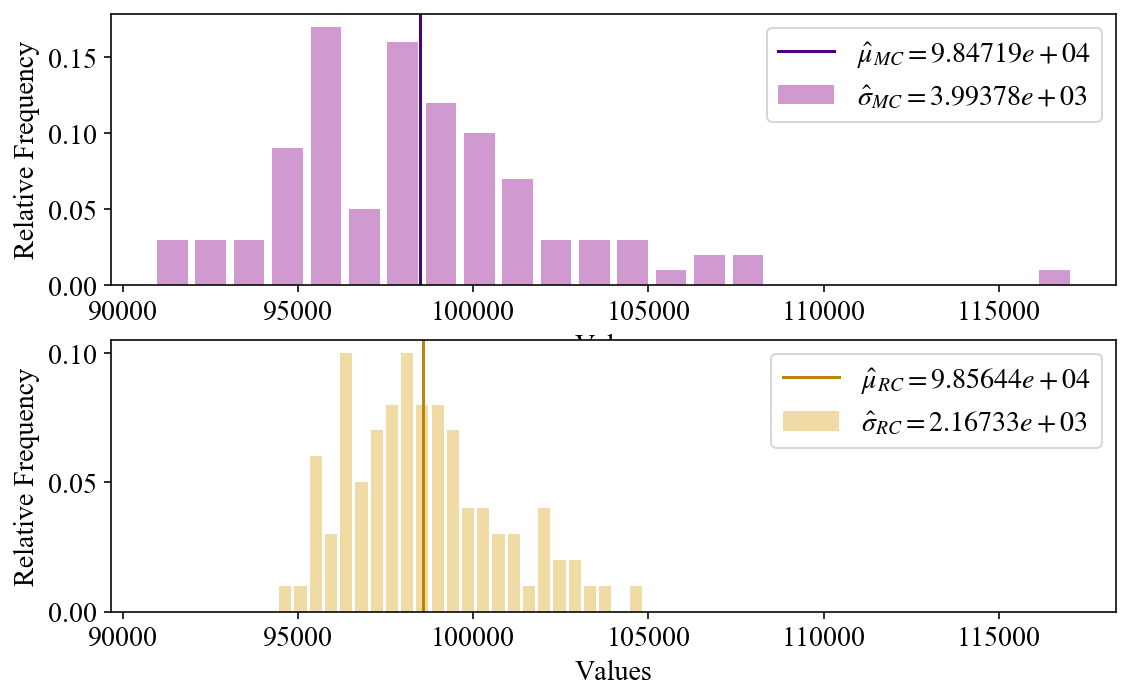

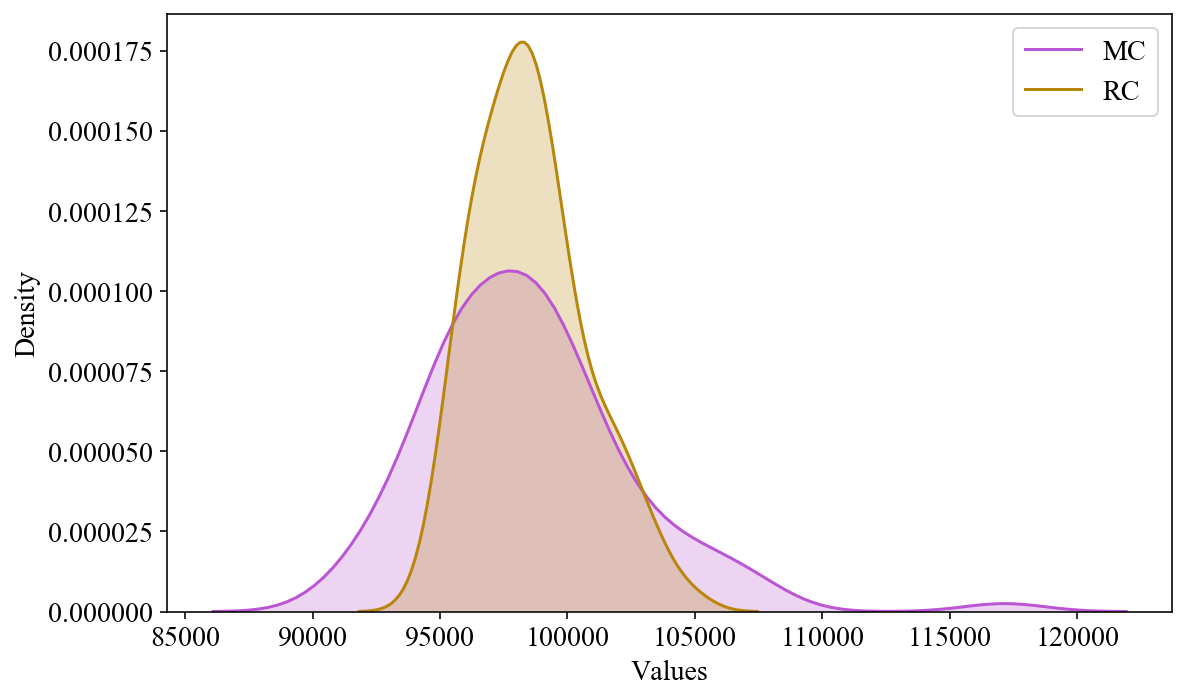

The decrease in variance when conditioning was 45.73%.


In [10]:
def loglog_mc(x, err):
    y = np.exp(9 + 3 * np.log(x) + err)
    mc = np.mean(y / x, axis=1)
    return mc


def loglog_rb(x):
    lognormal_err_mean = np.exp(0 + 1 / 2)
    rb = np.mean(np.exp(9) * x ** 2 * lognormal_err_mean, axis=1)
    return rb


def plot_mc(result_ary, bin_color, line_color, labels, *args, **kwargs):
    avg = result_ary.mean()
    std = result_ary.std()
    hst_lbl = f'$\\hat{{\\sigma}}_{{{labels[0]}}} = {std:.5e}$'
    hist = rel_freq_hist(result_ary, *args, bins=24, rwidth=0.8,
                         color=bin_color, alpha=0.4, label=hst_lbl, **kwargs)

    ln_lbl = f'$\\hat{{\mu}}_{{{labels[1]}}} = {avg:.5e}$'
    line = plt.axvline(avg, color=line_color, label=ln_lbl)
    return (hist, line)


x = np.exp(np.random.randn(replication, n_sample))
err = np.random.randn(replication, n_sample)
loglog_mc = loglog_mc(x, err)
loglog_rb = loglog_rb(x)

final_run = True
if final_run:
    # Rel. Freq
    plt.figure()
    top_ax = plt.subplot(211)
    plot_mc(loglog_mc, bin_color='DarkMagenta', line_color='Indigo',
            labels=('MC', 'MC'))
    plt.legend()

    bot_ax = plt.subplot(212)
    plot_mc(loglog_rb, bin_color='GoldenRod', line_color='DarkGoldenRod',
            labels=('RC', 'RC'))
    plt.legend()
    xlims = np.vstack((top_ax.get_xlim(), bot_ax.get_xlim()))
    xlims = (xlims.min(axis=0)[0], xlims.max(axis=0)[1])
    top_ax.set_xlim(xlims)
    bot_ax.set_xlim(xlims)

    # KDE
    plt.figure()
    sns.kdeplot(loglog_mc, shade=True, color='MediumOrchid', label='MC')
    sns.kdeplot(loglog_rb, shade=True, color='DarkGoldenRod', label='RC')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.show()


mc_std = loglog_mc.std()
rb_std = loglog_rb.std()
dec_rb = percent_change(mc_std, rb_std)
print(f'The decrease in variance when conditioning was {dec_rb:.2f}%.')



  So, Rao-Blackwellization will reduce variance and save computational
  complexity.